In [1]:
import tenseal as ts
import os
import utils
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pickle
from time import time

## Main

In [16]:
# Load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [17]:
# Slicing the MNIST original dataset to retain only part of the dataset.
x_train = x_train[:20000,:,:]
y_train = y_train[:20000]
x_test = x_test[:4000,:,:]
y_test  = y_test[:4000]

In [4]:
# Length of the new dataset
print("x_train:",len(x_train))
print("y_train:",len(y_train))
print("x_test:",len(x_test))
print("y_test:",len(y_test))

x_train: 20000
y_train: 20000
x_test: 4000
y_test: 4000


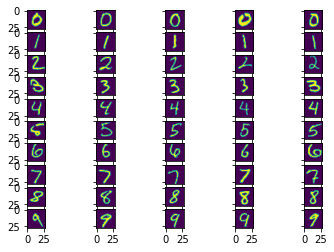

In [5]:
# Display a sample of the server dataset. 
digits = {}
for i in range(10):
    digits[i] = np.where(y_test==i)[0][:5]
#print(digits)

fig, ax = plt.subplots(10, 5, sharex='col', sharey='row')
for i in range(10):
    for j in range(5):
        ax[i, j].imshow(x_test[digits[i][j]])

In [6]:
# The model Architecture
# Model's architecture.
model_base = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='relu',use_bias=False, kernel_initializer='glorot_uniform'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax',use_bias=False, kernel_initializer='glorot_uniform')
])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7840      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compiling the model.
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [8]:
# Training the base_model.
model_base.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10


C:\Users\USER\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


157/157 [==============================] - 4s 10ms/step - loss: 1.5430 - sparse_categorical_accuracy: 0.4926 - val_loss: 1.0677 - val_sparse_categorical_accuracy: 0.7205
Epoch 2/10
157/157 [==============================] - 1s 7ms/step - loss: 0.9985 - sparse_categorical_accuracy: 0.6715 - val_loss: 0.7573 - val_sparse_categorical_accuracy: 0.7972
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.8084 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.6187 - val_sparse_categorical_accuracy: 0.8372
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.7178 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.5501 - val_sparse_categorical_accuracy: 0.8515
Epoch 5/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.7709 - val_loss: 0.5175 - val_sparse_categorical_accuracy: 0.8580
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6578 - sparse_categorical_accuracy

In [9]:
# Checking which layers have weights & bias.
for layer in model_base.layers:
    print(layer.name, len(layer.weights))

flatten 0
dense 1
dropout 0
dense_1 1


In [10]:
# Saving the model.
model_base.save('saved_model/base_model')

INFO:tensorflow:Assets written to: saved_model/base_model\assets


INFO:tensorflow:Assets written to: saved_model/base_model\assets


125/125 [==============================] - 1s 4ms/step
7


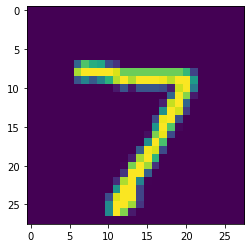

In [11]:
# Prediction 
predictions = model_base.predict(x_test)
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

In [24]:
#Accuracy and confusion matrix
# Creating a multiclass confusion matrix before training.
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

array([[357,   0,   2,   0,   1,   3,   5,   0,   2,   0],
       [  0, 435,   5,   2,   1,   0,   2,   0,   5,   0],
       [  4,   2, 357,  11,   4,   1,   6,   9,  23,   1],
       [  2,   1,  10, 352,   1,  19,   2,   9,   8,   4],
       [  1,   0,   3,   0, 383,   0,   7,   0,   4,  20],
       [ 10,   0,   0,  31,   7, 282,   3,   4,  30,   5],
       [ 15,   3,   4,   0,  10,   9, 331,   0,   6,   0],
       [  3,  18,  12,   5,   4,   0,   0, 346,   3,  20],
       [  5,   7,   8,  18,   7,  12,   2,   7, 313,   5],
       [  4,   4,   0,  10,  30,   0,   0,   8,   9, 326]], dtype=int64)

#### Create the CKKS scheme 

In [23]:
# Setup TenSEAL context.
context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
          
context.generate_galois_keys()
context.global_scale = 2**40

In [29]:
# Save the secret key 
#sk = context.secret_key()

# Creating a copy of the context to share with the server. Ideally, the secret key should be drop.
public_context = context
#public_context.make_context_public()

# Context and ciphertext serialization
server_context = public_context.serialize(save_secret_key=True)
print("Is the context private?", ("Yes" if public_context.is_private() else "No"))
print("Is the context public?", ("Yes" if public_context.is_public() else "No"))

Is the context private? Yes
Is the context public? No


In [30]:
key_query = {
    "context" : server_context
}

In [32]:
# Dump the context in a dictionary 
input_dictionary = (key_query)
file = open('key_query', 'wb')
pickle.dump(input_dictionary, file)
file.close()

In [ ]:
# load the serialized key from the file 
with open ("secret_key.bin", "rb") as file: 
    serialized_secret_key = file.read()

# Deserialize the secret key 
secret_key = ts.SecretKey()
secret_key.deserialize(serialized_secret_key)

## With Updated weight

### For Client 1

In [7]:
def decrypt_weights_x():
    # load the context key
    key_query_file = open('key_query', "rb")
    context_key = pickle.load(key_query_file)
    key_query_file.close()

    # recreate the key.
    context = ts.context_from(context_key["context"])
    
    # load the data from file
    client1_weights_file = open('client1_enc', "rb")
    client1_weights = pickle.load(client1_weights_file)
    client1_weights_file.close()
    
    # Recreating the CKKS encrypted tensors from their serialized counterparts.
    enc_x1 = ts.ckks_tensor_from(context, client1_weights["data1"])
    enc_x2 = ts.ckks_tensor_from(context, client1_weights["data2"])
    
    # Decrypting the 2 encrypted arrays to form the original weight array.
    t_start = time()
    denc_x1 = enc_x1.decrypt().tolist()
    denc_x2 = enc_x2.decrypt().tolist()
    t_end = time()
    print("weight decryption time for client: {} ms".format((t_end - t_start) * 1000))
    
    # Since the encrypyted array was splitted to cater for the 2GB limit, we restore the array to their original shape.
    denc_x = np.dstack((denc_x1, denc_x2))
    return denc_x
denc_x = decrypt_weights_x()

weight decryption time for client: 67870.0156211853 ms


In [ ]:
#denc_x[0]

### For Client 2

In [4]:
def decrypt_weights_y():
    # load the context key
    key_query_file = open('key_query', "rb")
    context_key = pickle.load(key_query_file)
    key_query_file.close()

    # recreate the key.
    context = ts.context_from(context_key["context"])
    
    # load the data from file
    client2_weights_file = open('client2_enc', "rb")
    client2_weights = pickle.load(client2_weights_file)
    client2_weights_file.close()
    
    # Recreating the CKKS encrypted tensors from their serialized counterparts.
    enc_y1 = ts.ckks_tensor_from(context, client2_weights["data1"])
    enc_y2 = ts.ckks_tensor_from(context, client2_weights["data2"])
    
    # Decrypting the 2 encrypted arrays to form the original weight array.
    t_start = time()
    denc_y1 = enc_y1.decrypt().tolist()
    denc_y2 = enc_y2.decrypt().tolist()
    t_end = time()
    print("weight decryption time for client: {} ms".format((t_end - t_start) * 1000))
    
    # Since the encrypyted array was splitted to cater for the 2GB limit, we restore the array to their original shape.
    denc_y = np.dstack((denc_y1, denc_y2))
    return denc_y
denc_y = decrypt_weights_y()

weight decryption time for client: 66448.94933700562 ms


### Make Average of the weights

In [9]:
def average_weight_scale ():
    result = (denc_x + denc_y)
    result_avg = result / 2
    return result_avg

In [10]:
average_model_weights = average_weight_scale ()

### Load the base model and update to create the updated model

In [12]:
# Loading the base_model.
new_model = tf.keras.models.load_model('saved_model/base_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7840      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                100       
                                                                 
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Update the the model with the updated weights
new_model.layers[1].set_weights(average_model_weights)

In [14]:
# Compiling the model.
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [18]:
# Training the updated_model.
new_model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10


C:\Users\USER\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


157/157 [==============================] - 38s 122ms/step - loss: 0.6276 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.4554 - val_sparse_categorical_accuracy: 0.8685
Epoch 2/10
157/157 [==============================] - 13s 84ms/step - loss: 0.5786 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.4424 - val_sparse_categorical_accuracy: 0.8695
Epoch 3/10
157/157 [==============================] - 13s 81ms/step - loss: 0.5630 - sparse_categorical_accuracy: 0.8096 - val_loss: 0.4311 - val_sparse_categorical_accuracy: 0.8727
Epoch 4/10
157/157 [==============================] - 15s 95ms/step - loss: 0.5475 - sparse_categorical_accuracy: 0.8139 - val_loss: 0.4207 - val_sparse_categorical_accuracy: 0.8712
Epoch 5/10
157/157 [==============================] - 14s 87ms/step - loss: 0.5482 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.4181 - val_sparse_categorical_accuracy: 0.8725
Epoch 6/10
157/157 [==============================] - 14s 87ms/step - loss: 0.5404 - sparse_categori

In [19]:
# save the model
new_model.save('saved_model/updated_model')

INFO:tensorflow:Assets written to: saved_model/updated_model\assets


INFO:tensorflow:Assets written to: saved_model/updated_model\assets


### Make Predictions

125/125 [==============================] - 8s 4ms/step
7


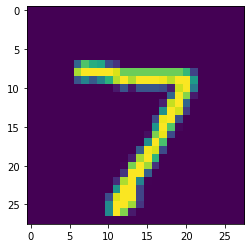

In [61]:
predictions = new_model.predict(x_test)
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

In [62]:
# Check the accuracy 
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

array([[355,   0,   3,   2,   0,   2,   6,   0,   2,   0],
       [  0, 437,   4,   1,   1,   0,   3,   0,   4,   0],
       [  6,   2, 364,   8,   4,   1,   9,   8,  15,   1],
       [  4,   1,  11, 347,   0,  22,   1,  10,   6,   6],
       [  2,   0,   4,   0, 380,   0,   5,   0,   5,  22],
       [ 14,   0,   3,  20,   6, 297,   5,   4,  17,   6],
       [ 15,   3,   8,   0,   6,   6, 338,   0,   2,   0],
       [  2,  15,  12,   3,   5,   0,   0, 357,   0,  17],
       [  6,   6,   9,  15,   3,  12,   3,   6, 310,  14],
       [  4,   4,   0,   8,  18,   1,   0,   8,   9, 339]], dtype=int64)

In [63]:
start_time = time.time()

In [64]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6119949817657471 seconds ---
